# Simply model compression

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
import h5py
import numpy as np


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def show(img):
    io.imshow(img)
    io.show()
def softmax_c(z):
    assert len(z.shape) == 2
    s = np.max(z, axis=1)
    s = s[:, np.newaxis]
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis] 
    return e_x / div

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 32, 32

Build model and load pretrain weight 

In [3]:

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(64, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=(img_rows, img_cols, 3)))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(5, 5),
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(96, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.load_weights('model_1/cifar10_model_weights.h5')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        4864      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
fla

In [4]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.525108920764923
Test accuracy: 0.6949


a little bad accuracy, anyway.

In [5]:
convparams = 4864 + 256 + 102464 + 256
trainable_params = model.count_params()
footprint = trainable_params * 4
print ("Memory footprint per Image Feed Forward ~= " , footprint / 1024.0 /1024.0 ,"Mb")

Memory footprint per Image Feed Forward ~=  2.0726699829101562 Mb


compute orignal size of parameters.

Next part is extra features.

In [ ]:
from matplotlib import pyplot as plt 
def prepare_softtargets(model,X):
        inp = model.input                                     
        outputs = []
        for layer in model.layers[:]:
            if layer.name == 'flatten_1':
                outputs.append(layer.output)
            if layer.name == 'dense_1':
                outputs.append(layer.output)
            if layer.name == 'dense_2':
                outputs.append(layer.output)
            if layer.name == 'dense_3':
                outputs.append(layer.output)
        functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function
        layer_outs = functor([X, 1.])
        return np.array(layer_outs[0]) , np.array(layer_outs[1]), np.array(layer_outs[2]), np.array(layer_outs[3])

    lastconv_out = []
    logit_out = []
    logit_out2 = []
    logit_out3 = []
    for i in range(0,50):
        print ("Batch # : ",i)
        f1,d1,d2, d3 =  (prepare_softtargets(model,x_train[i*1000:(i+1)*1000]))
        print(f1.shape)
        lastconv_out.append(f1)
        logit_out.append(d1)
        logit_out2.append(d2)
        logit_out3.append(d3)
        #lastconv_out , logit_out = prepare_softtargets(model,x_train[i*1000:(i+1)*1000])

    # lastconv_out.shape , logit_out.shape
    lastconv_out = np.array(lastconv_out)
    logit_out = np.array(logit_out)
    logit_out2 = np.array(logit_out2)
    logit_out3 = np.array(logit_out3)
    print(lastconv_out.shape)
    lastconv_out = lastconv_out.reshape((50000 , 1600))
    logit_out = logit_out.reshape((50000 , 256))
    logit_out2 = logit_out2.reshape((50000 , 96))
    logit_out3 = logit_out3.reshape((50000 , 10))
    print("lastconv_out = ",lastconv_out.shape,"logit_out = ",logit_out.shape,"logit_out2 = ",logit_out2.shape,"logit_out3 = ",logit_out3.shape)

    print("clean up ")
    x_train = 0

    h5f = h5py.File('model_1/lastconv_out.h5', 'w')
    h5f.create_dataset('dataset_1', data=lastconv_out)
    h5f.close()

    h5f2 = h5py.File('model_1/logit_out.h5', 'w')
    h5f2.create_dataset('dataset_1', data=logit_out)
    h5f2.close()

    h5f3 = h5py.File('model_1/logit_out2.h5', 'w')
    h5f3.create_dataset('dataset_1', data=logit_out2)
    h5f3.close()

    h5f4 = h5py.File('model_1/logit_out3.h5', 'w')
    h5f4.create_dataset('dataset_1', data=logit_out3)
    h5f4.close()

    # free up memory
    lastconv_out = 0
    logit_out = 0 
    logit_out2 = 0
    logit_out3 = 0

    # test data set
    lastconv_out = []
    logit_out = []
    logit_out2 = []
    logit_out3 = []

    for i in range(0,10):
        print ("Batch # : ",i)
        f1,d1,d2, d3 =  ( prepare_softtargets(model,x_test[i*1000:(i+1)*1000]))
        lastconv_out.append(f1)
        logit_out.append(d1)
        logit_out2.append(d2)
        logit_out3.append(d3)
        #lastconv_out , logit_out = prepare_softtargets(model,x_train[i*1000:(i+1)*1000])

    # lastconv_out.shape , logit_out.shape
    lastconv_out = np.array(lastconv_out)
    logit_out = np.array(logit_out)
    logit_out2 = np.array(logit_out2)
    logit_out3 = np.array(logit_out3)
    lastconv_out = lastconv_out.reshape((10000 , 1600))
    logit_out = logit_out.reshape((10000 , 256))
    logit_out2 = logit_out2.reshape((10000 , 96))
    logit_out3 = logit_out3.reshape((10000 , 10))


    h5f = h5py.File('model_1/test_lastconv_out.h5', 'w')
    h5f.create_dataset('dataset_1', data=lastconv_out)
    h5f.close()

    h5f2 = h5py.File('model_1/test_logit_out.h5', 'w')
    h5f2.create_dataset('dataset_1', data=logit_out)
    h5f2.close()

    h5f3 = h5py.File('model_1/test_logit_out2.h5', 'w')
    h5f3.create_dataset('dataset_1', data=logit_out2)
    h5f3.close()

    h5f4 = h5py.File('model_1/test_logit_out3.h5', 'w')
    h5f4.create_dataset('dataset_1', data=logit_out3)
    h5f4.close()

define plot function

In [11]:
from matplotlib import pyplot as plt
def plot_findings(results,name,save=False):
    fig = plt.figure()
    fig.suptitle('parameter Size and Accuracy', fontsize=20)
    plt.plot([r['nparams_student'] for r in results] , [r['accuracy_student'] for r in results])
    plt.xlabel('Parameter Size', fontsize=18)
    plt.ylabel('accuracy', fontsize=16)
    if save:  fig.savefig('model_1/plots/' + name + '_parameterSize_Accuracy.png')
#     plt.show()
    fig
    fig = plt.figure()
    fig.suptitle('Compression Rate and Accuracy', fontsize=20)
    plt.plot([r['compressionRate'] for r in results] , [r['accuracy_student'] for r in results])
    plt.xlabel('compression Rate', fontsize=18)
    plt.ylabel('accuracy', fontsize=18)
    if save:  fig.savefig('model_1/plots/' + name +'_CompressionRate_Accuracy.png')
#     plt.show()
    fig

finetunedense1_dense2 (default number parameter of dense2 is two time of dense1)
remind that test accuray only 0.6949

In [9]:
# finetunedense1_dense2
print('finetunedense1_dense2')
results = []
for HiddenNeuron in range(2,20,3):

    h5f = h5py.File('model_1/lastconv_out.h5', 'r')
    lastconv_out = h5f['dataset_1'][:]
    h5f.close()

    h5f4 = h5py.File('model_1/logit_out3.h5', 'r')
    logit_out3 = h5f4['dataset_1'][:]
    h5f4.close()

    student_model = Sequential()
    student_model.add(Dense(HiddenNeuron*2,input_dim=1600,activation='relu'))
    student_model.add(Dense(HiddenNeuron, activation='relu'))
    student_model.add(Dense(num_classes, activation='softmax'))

    student_model.compile(loss='mse',
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

    student_model.fit(lastconv_out, logit_out3,nb_epoch=40,verbose=0)
#     student_model.save_weights("student_weights_"+str(HiddenNeuron)+"hidden_0.5_dropout.h5")

    # Compression Rate from Number of Parameters Reduced
    dense2_dense1_para = 409856 + 24672

    print("dense1 and dense2 fine tune")
    print ("HiddenNeurons : " , HiddenNeuron)
    print ("Initial Parameters : " , model.count_params())
    print ("Compressed parameters: ", model.count_params() - dense2_dense1_para + student_model.count_params())
    compressionRate = model.count_params() / np.float(model.count_params() - dense2_dense1_para + student_model.count_params())
    print ("Compression Rate : " , compressionRate)

    lastconv_out = 0
    logit_out2 = 0                

    h5f = h5py.File('model_1/test_lastconv_out.h5', 'r')
    test_lastconv_out = h5f['dataset_1'][:]
    h5f.close()

    h5f4 = h5py.File('model_1/test_logit_out3.h5', 'r')
    test_logit_out = h5f4['dataset_1'][:]
    h5f4.close()

    pred = student_model.predict(test_lastconv_out)
    probs = softmax_c(pred)
    pred_classes = np.argmax(probs,axis=1)

    accuracy_student = metrics.accuracy_score(y_pred=pred_classes,y_true=np.argmax(y_test,axis=1))
    print ("Accuracy compare with test set: " , accuracy_student)

    out = {
        "HiddenNeuron" :    HiddenNeuron,
        "compressionRate" : compressionRate,
        "nparams_student" : student_model.count_params()  + convparams,
        "accuracy_student": accuracy_student
    }

    student_model = 0 
    lastconv_out = 0
    logit_out = 0 
    test_lastconv_out = 0
    test_logit_out = 0 
    results.append(out)

finetunedense1_dense2


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


dense1 and dense2 fine tune
HiddenNeurons :  2
Initial Parameters :  543338
Compressed parameters:  115254
Compression Rate :  4.714265882312111
Accuracy compare with test set:  0.4943
dense1 and dense2 fine tune
HiddenNeurons :  5
Initial Parameters :  543338
Compressed parameters:  124935
Compression Rate :  4.348965462040261
Accuracy compare with test set:  0.6556
dense1 and dense2 fine tune
HiddenNeurons :  8
Initial Parameters :  543338
Compressed parameters:  134652
Compression Rate :  4.035127588153165
Accuracy compare with test set:  0.6729
dense1 and dense2 fine tune
HiddenNeurons :  11
Initial Parameters :  543338
Compressed parameters:  144405
Compression Rate :  3.762598247983103
Accuracy compare with test set:  0.6767
dense1 and dense2 fine tune
HiddenNeurons :  14
Initial Parameters :  543338
Compressed parameters:  154194
Compression Rate :  3.523729846816348
Accuracy compare with test set:  0.6775
dense1 and dense2 fine tune
HiddenNeurons :  17
Initial Parameters :  543

finetunedense1_dense2 =  [{'HiddenNeuron': 2, 'compressionRate': 4.714265882312111, 'nparams_student': 114284, 'accuracy_student': 0.4943}, {'HiddenNeuron': 5, 'compressionRate': 4.348965462040261, 'nparams_student': 123965, 'accuracy_student': 0.6556}, {'HiddenNeuron': 8, 'compressionRate': 4.035127588153165, 'nparams_student': 133682, 'accuracy_student': 0.6729}, {'HiddenNeuron': 11, 'compressionRate': 3.762598247983103, 'nparams_student': 143435, 'accuracy_student': 0.6767}, {'HiddenNeuron': 14, 'compressionRate': 3.523729846816348, 'nparams_student': 153224, 'accuracy_student': 0.6775}, {'HiddenNeuron': 17, 'compressionRate': 3.312652802419232, 'nparams_student': 163049, 'accuracy_student': 0.6826}]


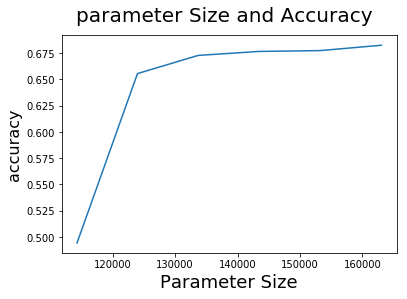

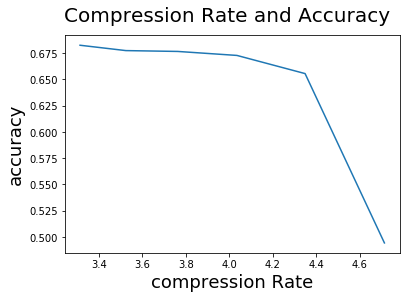

In [12]:
print('finetunedense1_dense2 = ',results)
plot_findings(results,'dense1_dense2',save=True)

Try to reduce two dense to one dense layer to see the difference

In [14]:
# reduce layer
print('reduce layer')
results = []
for HiddenNeuron in range(2,15,3):

    h5f = h5py.File('model_1/lastconv_out.h5', 'r')
    lastconv_out = h5f['dataset_1'][:]
    h5f.close()

    h5f4 = h5py.File('model_1/logit_out3.h5', 'r')
    logit_out3 = h5f4['dataset_1'][:]
    h5f4.close()

    student_model = Sequential()
    student_model.add(Dense(HiddenNeuron,input_dim=1600,activation='relu'))
    student_model.add(Dense(num_classes, activation='softmax'))

    student_model.compile(loss='mse',
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

    student_model.fit(lastconv_out, logit_out3,nb_epoch=40,verbose=0)
#     student_model.save_weights("student_weights_"+str(HiddenNeuron)+"hidden_0.5_dropout.h5")

    # Compression Rate from Number of Parameters Reduced
    dense2_dense1_para = 409856 + 24672

    print("dense1 and dense2 fine tune")
    print ("HiddenNeurons : " , HiddenNeuron)
    print ("Initial Parameters : " , model.count_params())
    print ("Compressed parameters: ", model.count_params() - dense2_dense1_para + student_model.count_params())
    compressionRate = model.count_params() / np.float(model.count_params() - dense2_dense1_para + student_model.count_params())
    print ("Compression Rate : " , compressionRate)

    lastconv_out = 0
    logit_out2 = 0                

    h5f = h5py.File('model_1/test_lastconv_out.h5', 'r')
    test_lastconv_out = h5f['dataset_1'][:]
    h5f.close()

    h5f4 = h5py.File('model_1/test_logit_out3.h5', 'r')
    test_logit_out = h5f4['dataset_1'][:]
    h5f4.close()

    pred = student_model.predict(test_lastconv_out)
    probs = softmax_c(pred)
    pred_classes = np.argmax(probs,axis=1)

    accuracy_student = metrics.accuracy_score(y_pred=pred_classes,y_true=np.argmax(y_test,axis=1))
    print ("Accuracy compare with test set: " , accuracy_student)

    out = {
        "HiddenNeuron" :    HiddenNeuron,
        "compressionRate" : compressionRate,
        "nparams_student" : student_model.count_params()  + convparams,
        "accuracy_student": accuracy_student
    }

    student_model = 0 
    lastconv_out = 0
    logit_out = 0 
    test_lastconv_out = 0
    test_logit_out = 0 

    results.append(out)

reduce layer


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


dense1 and dense2 fine tune
HiddenNeurons :  2
Initial Parameters :  543338
Compressed parameters:  112042
Compression Rate :  4.849413612752361
Accuracy compare with test set:  0.4383
dense1 and dense2 fine tune
HiddenNeurons :  5
Initial Parameters :  543338
Compressed parameters:  116875
Compression Rate :  4.64888128342246
Accuracy compare with test set:  0.6154
dense1 and dense2 fine tune
HiddenNeurons :  8
Initial Parameters :  543338
Compressed parameters:  121708
Compression Rate :  4.464275150359878
Accuracy compare with test set:  0.6702
dense1 and dense2 fine tune
HiddenNeurons :  11
Initial Parameters :  543338
Compressed parameters:  126541
Compression Rate :  4.293770398526959
Accuracy compare with test set:  0.6649
dense1 and dense2 fine tune
HiddenNeurons :  14
Initial Parameters :  543338
Compressed parameters:  131374
Compression Rate :  4.135810738806765
Accuracy compare with test set:  0.6693


remove_d1_d2 =  [{'HiddenNeuron': 2, 'compressionRate': 4.849413612752361, 'nparams_student': 111072, 'accuracy_student': 0.4383}, {'HiddenNeuron': 5, 'compressionRate': 4.64888128342246, 'nparams_student': 115905, 'accuracy_student': 0.6154}, {'HiddenNeuron': 8, 'compressionRate': 4.464275150359878, 'nparams_student': 120738, 'accuracy_student': 0.6702}, {'HiddenNeuron': 11, 'compressionRate': 4.293770398526959, 'nparams_student': 125571, 'accuracy_student': 0.6649}, {'HiddenNeuron': 14, 'compressionRate': 4.135810738806765, 'nparams_student': 130404, 'accuracy_student': 0.6693}]


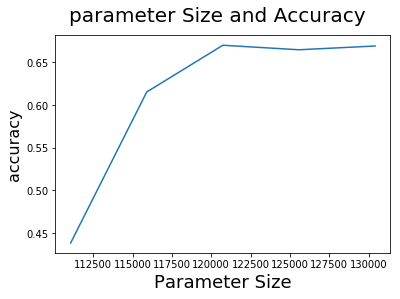

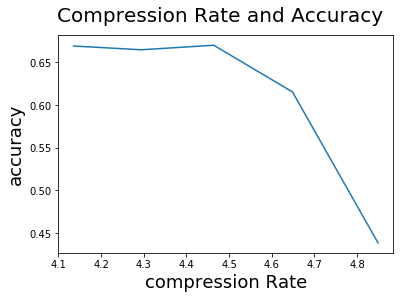

In [15]:
print('remove_d1_d2 = ', results)
plot_findings(results,'remove_d1_d2',save=True)

define new plot function cuz accuracy item different. (in order to save time @@)

In [20]:
def plot_findings2(results,name,save=False):
    fig = plt.figure()
    fig.suptitle('parameter Size and dense2 Accuracy', fontsize=20)
    plt.plot([r['nparams_student'] for r in results] , [r['accuracy_student_premodel_prediction'][1] for r in results])
    plt.xlabel('Parameter Size', fontsize=18)
    plt.ylabel('accuracy', fontsize=16)
    if save:  fig.savefig('model_1/plots/' + name + '_parameterSize_Accuracy.png')
    # plt.show()
    fig
    fig = plt.figure()
    fig.suptitle('Compression Rate and dense2 Accuracy', fontsize=20)
    plt.plot([r['compressionRate'] for r in results] , [r['accuracy_student_premodel_prediction'][1] for r in results])
    plt.xlabel('compression Rate', fontsize=18)
    plt.ylabel('accuracy', fontsize=18)
    if save:  fig.savefig('model_1/plots/' + name +'_CompressionRate_Accuracy.png')
    # plt.show()
    fig

only fine tune dense2 layer to see the results
the accuracy is compare with previous dense2 layer.

In [17]:
# finetunedense2
print('finetunedense2')
results = []
for HiddenNeuron in range(96,256,30):

    h5f = h5py.File('model_1/lastconv_out.h5', 'r')
    lastconv_out = h5f['dataset_1'][:]
    h5f.close()

    h5f3 = h5py.File('model_1/logit_out2.h5', 'r')
    logit_out2 = h5f3['dataset_1'][:]
    h5f3.close()

    student_model = Sequential()
    student_model.add(Dense(HiddenNeuron,input_dim=1600,activation='relu'))
    student_model.add(Dense(96, activation='relu'))

    student_model.compile(loss='mse',
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

    student_model.fit(lastconv_out, logit_out2,nb_epoch=40,verbose=0)
#     student_model.save_weights("student_weights_"+str(HiddenNeuron)+"hidden_0.5_dropout.h5")

    # Compression Rate from Number of Parameters Reduced
    dense2_para = 409856

    print("dense2 fine tune")
    print ("HiddenNeurons : " , HiddenNeuron)
    print ("Initial  Parameters : " , model.count_params())
    print ("Compressed dense2 parameters: ", model.count_params() - dense2_para + student_model.count_params())
    compressionRate = model.count_params() / np.float(model.count_params() - dense2_para + student_model.count_params())
    print ("Compression Rate : " , compressionRate)

    lastconv_out = 0
    logit_out2 = 0                

    h5f = h5py.File('model_1/test_lastconv_out.h5', 'r')
    test_lastconv_out = h5f['dataset_1'][:]
    h5f.close()

    h5f3 = h5py.File('model_1/test_logit_out2.h5', 'r')
    test_logit_out = h5f3['dataset_1'][:]
    h5f3.close()

    accuracy_student = student_model.evaluate(test_lastconv_out, test_logit_out)
    # accuracy_student = rfr.score(y_pred=np.array(pred),y_true=np.array(test_logit_out))
    print ("Accuracy compare with previous model prediction: " , accuracy_student[1])

    out = {
        "HiddenNeuron" :    HiddenNeuron,
        "compressionRate" : compressionRate,
        "nparams_student" : student_model.count_params()  + convparams,
        "accuracy_student_premodel_prediction": accuracy_student
    }

    student_model = 0 
    lastconv_out = 0
    logit_out = 0 
    test_lastconv_out = 0
    test_logit_out = 0 

    results.append(out)

finetunedense2


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


dense2 fine tune
HiddenNeurons :  96
Initial  Parameters :  543338
Compressed dense2 parameters:  296490
Compression Rate :  1.8325677088603325
10000/10000 [==============================] - 1s 63us/step
Accuracy compare with previous model prediction:  0.6092
dense2 fine tune
HiddenNeurons :  126
Initial  Parameters :  543338
Compressed dense2 parameters:  347400
Compression Rate :  1.5640126655152562
10000/10000 [==============================] - 1s 68us/step
Accuracy compare with previous model prediction:  0.6567
dense2 fine tune
HiddenNeurons :  156
Initial  Parameters :  543338
Compressed dense2 parameters:  398310
Compression Rate :  1.3641083578117548
10000/10000 [==============================] - 1s 72us/step
Accuracy compare with previous model prediction:  0.6952
dense2 fine tune
HiddenNeurons :  186
Initial  Parameters :  543338
Compressed dense2 parameters:  449220
Compression Rate :  1.2095142691776857
10000/10000 [==============================] - 1s 74us/step
Accuracy c

finetunedense2 =  [{'HiddenNeuron': 96, 'compressionRate': 1.8325677088603325, 'nparams_student': 270848, 'accuracy_student_premodel_prediction': [1.674135507774353, 0.6092]}, {'HiddenNeuron': 126, 'compressionRate': 1.5640126655152562, 'nparams_student': 321758, 'accuracy_student_premodel_prediction': [1.431967215538025, 0.6567]}, {'HiddenNeuron': 156, 'compressionRate': 1.3641083578117548, 'nparams_student': 372668, 'accuracy_student_premodel_prediction': [0.9135502194404602, 0.6952]}, {'HiddenNeuron': 186, 'compressionRate': 1.2095142691776857, 'nparams_student': 423578, 'accuracy_student_premodel_prediction': [0.6473811587333679, 0.7516]}, {'HiddenNeuron': 216, 'compressionRate': 1.0863935376802032, 'nparams_student': 474488, 'accuracy_student_premodel_prediction': [0.3772724949836731, 0.8094]}, {'HiddenNeuron': 246, 'compressionRate': 0.986022793263647, 'nparams_student': 525398, 'accuracy_student_premodel_prediction': [0.19780712876319886, 0.8904]}]


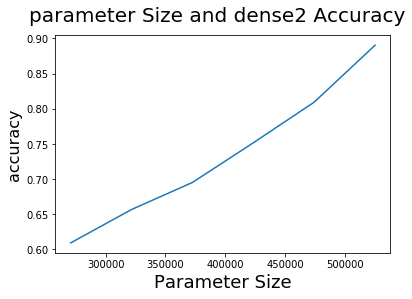

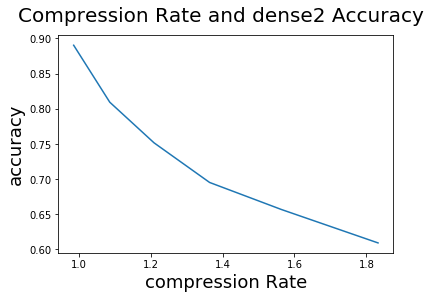

In [21]:
print('finetunedense2 = ',results)
plot_findings2(results,'dense2',save=True)

# Future work
1.Try to use fine tune dense2 layer to add back to the model and further fine tune dense1 layer.
2.Try to reduce conv layer with same concept (maybe random reduce number of connecting layer to see the correlation of accuray and parameters)